# **Cancer Detection from Scans**

In [1]:
import sys
!{sys.executable} -m pip install pandas kaggle numpy matplotlib seaborn opencv-python pillow scikit-learn keras-tuner


In [2]:
import sys
!{sys.executable} -m pip install tensorflow-metal tensorflow-macos


In [3]:
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import seaborn
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.16.2


# Problem & Data
I need to build a neural network that can perform binary image classification on a dataset containing digital pathology scans from the [Histopathologic Cancer Detection Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/leaderboard)

In [4]:
# check that I am properly enabling the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# download the data
!kaggle competitions download -c histopathologic-cancer-detection

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
# extract the data from zip
with zipfile.ZipFile("histopathologic-cancer-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")


First, I'll look at our training label data.

There is a csv containing the IDs and labels for use in training.

In [4]:
# create training data from CSV of IDs and Labels
train_labels = pd.read_csv("data/train_labels.csv")

# take a look at a sample of our data
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


There are 220,025 images in this dataset. The `id` column indicates the name of the image file. We will use that to retrieve the images from the `train` directory. The `label` column indicates whether the training image contains a tumor (1) or does not contain a tumor (0).

In [6]:
print(train_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


# EDA

My plan for EDA is as follows: 
1. Analyze at the data to ensure that there are no null values within the train data set.
2. Visualize data with class, RGB, and pixel value distribution graphs.
3. Sample some images to see what they actually look like.
4. Check that the sizes of the images appear uniform.
5. Split the train data into a training set and a validation set.
6. Preprocess the data and shrink the images slightly to improve computation performance.

Comments within the code describe the processes as necessary.

In [7]:
# check for any null values in the training set
print(train_labels.isnull().sum())

id       0
label    0
dtype: int64


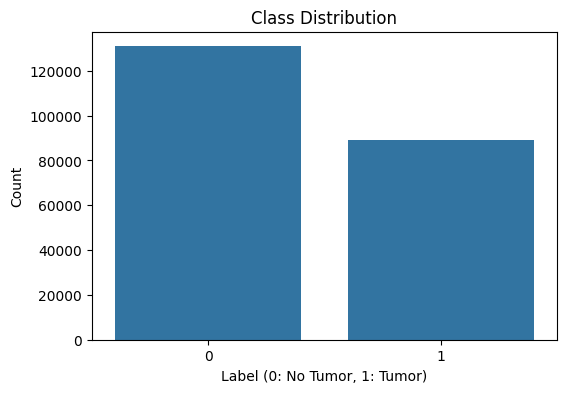

Class Distribution:
 label
0    59.496875
1    40.503125
Name: proportion, dtype: float64


In [8]:
# plot the distribution of training data between tumor and no tumor
plt.figure(figsize=(6, 4))
seaborn.countplot(x='label', data=train_labels)
plt.title('Class Distribution')
plt.xlabel('Label (0: No Tumor, 1: Tumor)')
plt.ylabel('Count')
plt.show()

print("Class Distribution:\n", train_labels['label'].value_counts(normalize=True) * 100)

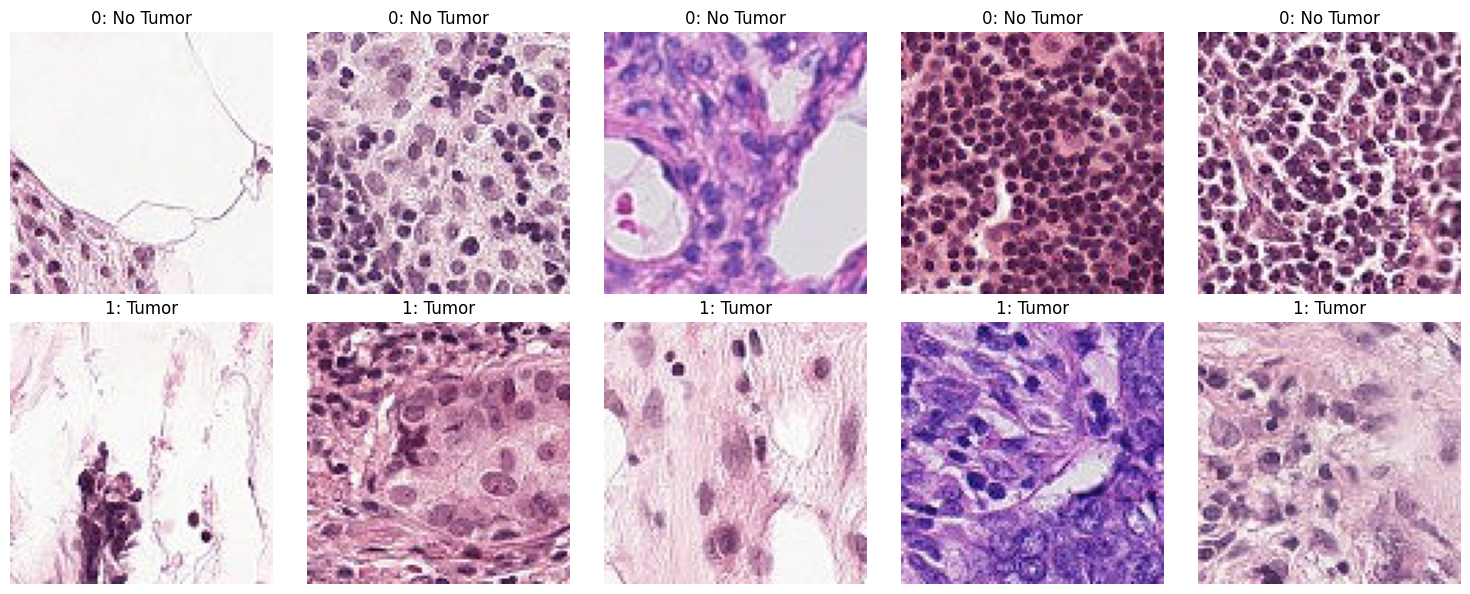

In [9]:
# visualize samples of images from each class

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    image = Image.open(f'data/train/{train_labels[train_labels["label"] == 0].iloc[i]["id"]}.tif')
    ax[0, i].imshow(image)
    ax[0, i].axis('off')
    ax[0, i].set_title('0: No Tumor')
    image = Image.open(f'data/train/{train_labels[train_labels["label"] == 1].iloc[i]["id"]}.tif')
    ax[1, i].imshow(image)
    ax[1, i].axis('off')
    ax[1, i].set_title('1: Tumor')

plt.tight_layout()
plt.show()

In [18]:
# look at a sample of 1000 images to check their sizes
image_sizes = []
for img_id in train_labels['id'].sample(1000):
    with Image.open(f'data/train/{img_id}.tif') as img:
        image_sizes.append(img.size)

print("Image sizes present in dataset:", set(image_sizes))

Image sizes present in dataset: {(96, 96)}


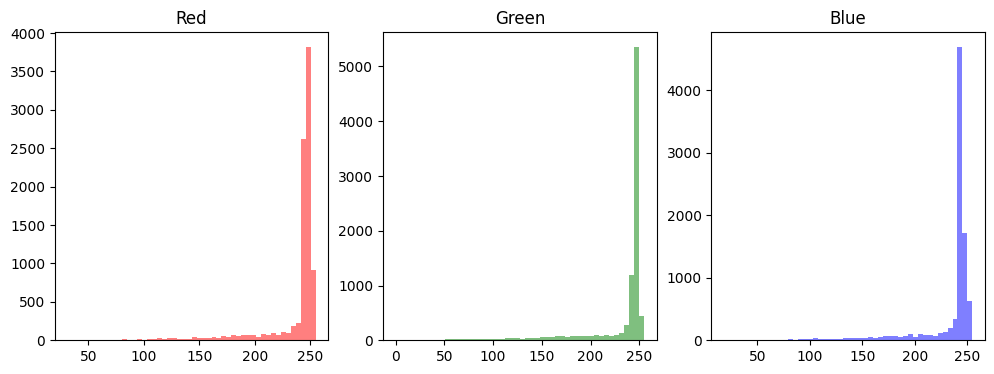

In [11]:
# plot the distribution of RGB values within the images present in the training data
def color_dist(path):
    image = Image.open(path)
    r, g, b = image.split()
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(np.array(r).flatten(), bins=50, color='red', alpha=0.5)
    plt.title('Red')

    plt.subplot(1, 3, 2)
    plt.hist(np.array(g).flatten(), bins=50, color='green', alpha=0.5)
    plt.title('Green')

    plt.subplot(1, 3, 3)
    plt.hist(np.array(b).flatten(), bins=50, color='blue', alpha=0.5)
    plt.title('Blue')

    plt.show()
color_dist(os.path.join('data/train', train_labels.iloc[0]['id'] + '.tif'))


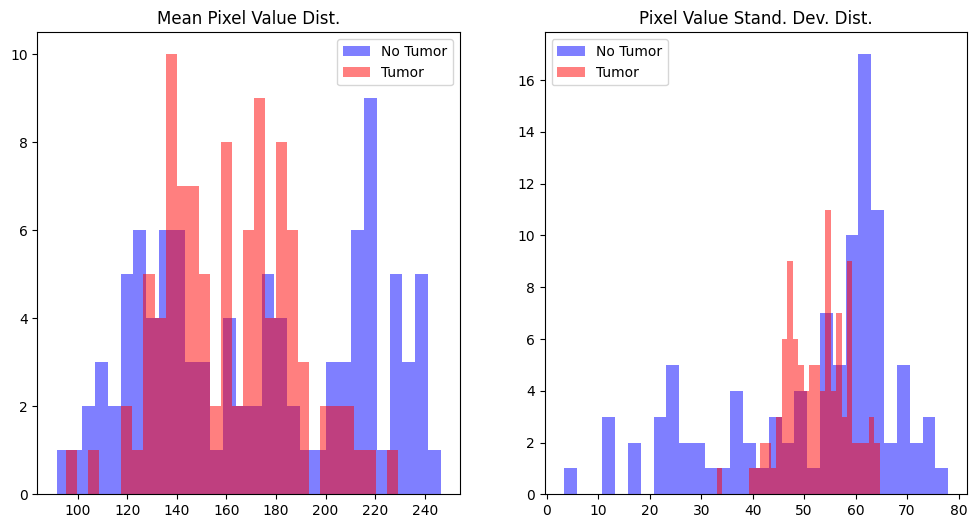

In [12]:

def image_stats(image_ids):
    means, stds = [], []
    for img_id in image_ids:
        img = np.array(Image.open(f'data/train/{img_id}.tif'))
        means.append(np.mean(img))
        stds.append(np.std(img))
    return means, stds

benign_ids = train_labels[train_labels['label'] == 0]['id'].sample(100)
tumor_ids = train_labels[train_labels['label'] == 1]['id'].sample(100)

benign_means, benign_stds = image_stats(benign_ids)
tumor_means, tumor_stds = image_stats(tumor_ids)

plt.figure(figsize=(12, 6))

# overlay the mean pixel value distributions of the images of each class

plt.subplot(1, 2, 1)
plt.hist(benign_means, alpha=0.5, color='blue', bins=30, label='No Tumor')
plt.hist(tumor_means, alpha=0.5, color='red', bins=30, label='Tumor')
plt.title('Mean Pixel Value Dist.')
plt.legend()


# overlay the mean pixel value standard distribution of the images of each class

plt.subplot(1, 2, 2)
plt.hist(benign_stds, alpha=0.5, color='blue', bins=30, label='No Tumor')
plt.hist(tumor_stds, alpha=0.5, color='red', bins=30, label='Tumor')
plt.title('Pixel Value Stand. Dev. Dist.')
plt.legend()

plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# create training and validation sets from the train data

train, val = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=29
)

print(f"Training size: {len(train)}")
print(f"Validation size: {len(val)}")

Training set size: 176020
Validation set size: 44005


In [6]:
# transform data into format that tensorflow can interpret and work with
train_dataset = tf.data.Dataset.from_tensor_slices((train['id'].values, train['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val['id'].values, val['label'].values))

# function for preprocessing images including a line to shrink the images a bit to improve training speed
def preprocess_image(path, label):
    full_path = tf.strings.join(['data/train/', path, '.tif'])
    image = tf.py_function(load_tif, [full_path], tf.float32)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0

    label = tf.cast(label, tf.float32)
    return image, label

def load_tif(path):
    image = Image.open(path.numpy().decode('utf-8'))
    image = image.convert('RGB')
    image_arr = np.array(image).astype(np.float32)
    return image_arr

batch_size = 32
buffer_size = 10000


# preprocess training images and shuffle training set
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size).prefetch(buffer_size=buffer_size)

# preprocess validation images
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=10000)


2024-09-24 12:41:53.357922: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-24 12:41:53.357970: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-24 12:41:53.357981: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-24 12:41:53.358016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-24 12:41:53.358042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model & Training

## Architecture & Reasoning

Throughout this process, I will use AUC as a performance metric because this is a binary classification task and because the competition is scored using this metric.

First, I will start with a basic model with one convolutional layer and a small number of epochs to set a performance baseline. 
* I use the input size of 64 x 64 to match the image sizes.
* I'll use SeparableConv2D for computational efficiency.
* I'll just use one convolutional layer followed by pooling to make the initial iteration process quicker.
* I use MaxPooling2D for dimensionality reduction and GlobalAveragePooling2D to reduce the overfitting.
* Because this is a binary classification use case, I use a sigmoid activation function and binary cross-entropy as a loss function
* I'll use Adam for its efficiency and faster convergence.

Then, I will work more complexity into my architecture with hyperparameter tuning.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SeparableConv2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [25]:
# instantiate the model
model_baseline = Sequential()

In [26]:
# add layers to model
model_baseline.add(Input(shape=(64, 64, 3)))
model_baseline.add(SeparableConv2D(32, (3, 3), activation='relu'))
model_baseline.add(MaxPooling2D((2, 2)))
model_baseline.add(GlobalAveragePooling2D())
model_baseline.add(Dense(1, activation='sigmoid'))

In [27]:
# compile using adam and binary_crossentropy with the performance metric of AUC
model_baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [28]:
# fit model using GPU and a smaller number of epochs for iteration efficiency
with tf.device('/GPU:0'):
    history_baseline = model_baseline.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        batch_size=64
    )

Epoch 1/10


2024-09-20 06:48:19.889315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 6044 of 10000
2024-09-20 06:48:23.554358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 274s 47ms/step - AUC: 0.7751 - loss: 0.5853 - val_AUC: 0.8548 - val_loss: 0.4664
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 264s 46ms/step - AUC: 0.8549 - loss: 0.4643 - val_AUC: 0.8644 - val_loss: 0.4511
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 271s 48ms/step - AUC: 0.8637 - loss: 0.4506 - val_AUC: 0.8715 - val_loss: 0.4420
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 262s 46ms/step - AUC: 0.8703 - loss: 0.4402 - val_AUC: 0.8754 - val_loss: 0.4326
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 267s 47ms/step - AUC: 0.8745 - loss: 0.4331 - val_AUC: 0.8793 - val_loss: 0.4323
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 273s 48ms/step - AUC: 0.8783 - loss: 0.4265 - val_AUC: 0.8814 - val_loss: 0.4222
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 274s 48ms/step - AUC: 0.8810 - loss: 0.4218 - val_AUC: 0.8853 - val_loss: 0.4158
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 271s 48ms/step - AUC: 0.8833 - loss: 0.4181 - val_AUC: 0.8837 - val_loss: 0.4159
Epoch 9/10
5501/5501 ━━━━━━

In [29]:
# check AUC and loss on the validation set using the fitted model
validation_loss, validation_AUC = model_baseline.evaluate(val_dataset)
print(f'Validation AUC: {validation_AUC:.2f}')
print(f'Validation Loss: {validation_loss:.2f}')

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - AUC: 0.8883 - loss: 0.4169
Validation AUC: 0.89
Validation Loss: 0.42


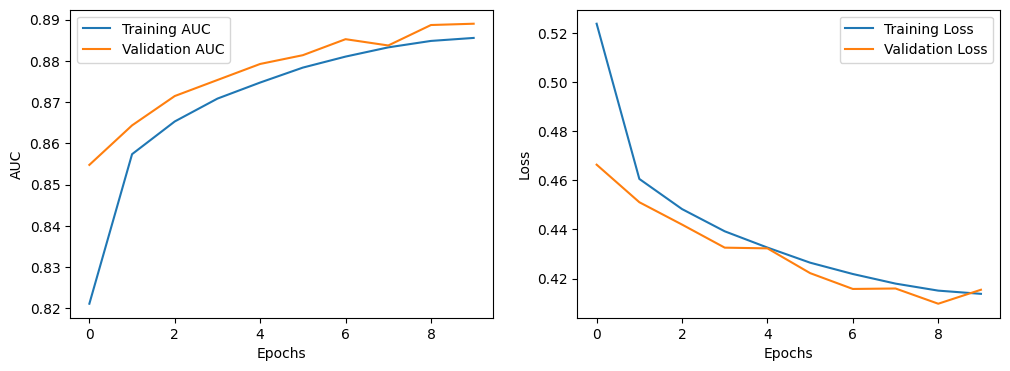

In [30]:
plt.figure(figsize=(12, 4))

# plot AUC against epoch number
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['AUC'], label='Training AUC')
plt.plot(history_baseline.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# plot Loss against epoch number
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Hyperparameter Tuning

Next, I will iterate on the model as well as apply hyperparameter tuning. I...

* introduced EarlyStopping and ReduceLROnPlateau as callbacks to improve the efficiency of my model and further reduce overfitting. EarlyStopping especially helps prevent diminishing returns and wasted training time. ReduceLROnPlateau reduced the risk of overshooting the minima.
* increased my depth with more convolutional layers to discover more complex pattens
* incorporated dropout for regularization to prevent overfitting
* implemented batch normalization to stabalize the training process
* tried implementing different optimizers (found that using RMSprop improved the performance of the model in this case)
* increased the number of epochs

This process took a long time -- that was the toughest part. I spent days tweaking the model and letting it run before finally getting a performance on AUC I was happy with.

In [8]:
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hyperparams):
    model_t = Sequential()

    model_t.add(Input(shape=(64, 64, 3)))

    model_t.add(Conv2D(
        filters=hyperparams.Int('conv_1_filter', min_value=32, max_value=64, step=16),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model_t.add(BatchNormalization())
    model_t.add(MaxPooling2D((2, 2)))

    model_t.add(Conv2D(
        filters=hyperparams.Int('conv_2_filter', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model_t.add(MaxPooling2D(pool_size=(2, 2)))

    model_t.add(Conv2D(
        filters=hyperparams.Int('conv_3_filter', min_value=128, max_value=256, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model_t.add(MaxPooling2D(pool_size=(2, 2)))

    model_t.add(GlobalAveragePooling2D())

    model_t.add(Dropout(rate=hyperparams.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)))

    model_t.add(Dense(1, activation='sigmoid'))

    model_t.compile(optimizer=RMSprop(
        learning_rate=hyperparams.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['AUC'])

    return model_t


In [9]:
tuner = RandomSearch(
    build_model,
    objective='val_AUC',
    max_trials=6,
    executions_per_trial=1,
    directory='out',
    project_name='hyperparameter_tuning_4'
)




Reloading Tuner from out/hyperparameter_tuning_4/tuner0.json


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

tuner.search_space_summary()

reduce_lr = ReduceLROnPlateau(monitor='val_AUC', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('model_{epoch}.keras', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_AUC', mode='max', patience=3, restore_best_weights=True)


with tf.device('/GPU:0'):
    tuner.search(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping,checkpoint],
        verbose=1 
    )
tuner.results_summary()



Search space summary
Default search space size: 5
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
Results summary
Results in out/hyperparameter_tuning_4
Showing 10 best trials
Objective(name="val_AUC", direction="max")

Trial 2 summary
Hyperparameters:
conv_1_filter: 64
conv_2_filter: 128
conv_3_filter: 224
dropout_rate: 0.2
learning_rate: 0.00013129266189802584
Score: 0.9666162133216858

Trial 3 summary
Hype

In [11]:
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparams)

In [12]:
early_stopping = EarlyStopping(monitor='val_AUC', mode='max', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_AUC', factor=0.2, patience=2, min_lr=1e-6)

In [13]:
history_best_model = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2024-09-24 12:42:23.899325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 502s 90ms/step - AUC: 0.8769 - loss: 0.4258 - val_AUC: 0.9206 - val_loss: 0.3571 - learning_rate: 1.3129e-04
Epoch 2/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 500s 89ms/step - AUC: 0.9239 - loss: 0.3433 - val_AUC: 0.9444 - val_loss: 0.2986 - learning_rate: 1.3129e-04
Epoch 3/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 496s 89ms/step - AUC: 0.9397 - loss: 0.3062 - val_AUC: 0.9523 - val_loss: 0.2736 - learning_rate: 1.3129e-04
Epoch 4/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 535s 96ms/step - AUC: 0.9559 - loss: 0.2616 - val_AUC: 0.9614 - val_loss: 0.2492 - learning_rate: 2.6259e-05
Epoch 5/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 560s 100ms/step - AUC: 0.9597 - loss: 0.2500 - val_AUC: 0.9640 - val_loss: 0.2428 - learning_rate: 2.6259e-05
Epoch 6/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 557s 100ms/step - AUC: 0.9632 - loss: 0.2393 - val_AUC: 0.9654 - val_loss: 0.2343 - learning_rate: 5.2517e-06
Epoch 7/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 545s 97ms/step - AUC: 0.9637 - loss: 0.2374 - val_AUC: 0.9662

2024-09-24 13:44:09.136167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 9676 of 10000
2024-09-24 13:44:09.425650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 539s 96ms/step - AUC: 0.9641 - loss: 0.2362 - val_AUC: 0.9665 - val_loss: 0.2294 - learning_rate: 1.0503e-06
Epoch 9/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 527s 94ms/step - AUC: 0.9645 - loss: 0.2348 - val_AUC: 0.9668 - val_loss: 0.2302 - learning_rate: 1.0503e-06
Epoch 10/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 506s 90ms/step - AUC: 0.9646 - loss: 0.2344 - val_AUC: 0.9667 - val_loss: 0.2286 - learning_rate: 1.0000e-06
Epoch 11/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 518s 93ms/step - AUC: 0.9648 - loss: 0.2335 - val_AUC: 0.9667 - val_loss: 0.2282 - learning_rate: 1.0000e-06


In [14]:
validation_loss, validation_AUC = best_model.evaluate(val_dataset)
print(f'Validation AUC: {validation_AUC:.2f}')
print(f'Validation Loss: {validation_loss:.2f}')

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - AUC: 0.9671 - loss: 0.2291
Validation AUC: 0.97
Validation Loss: 0.23


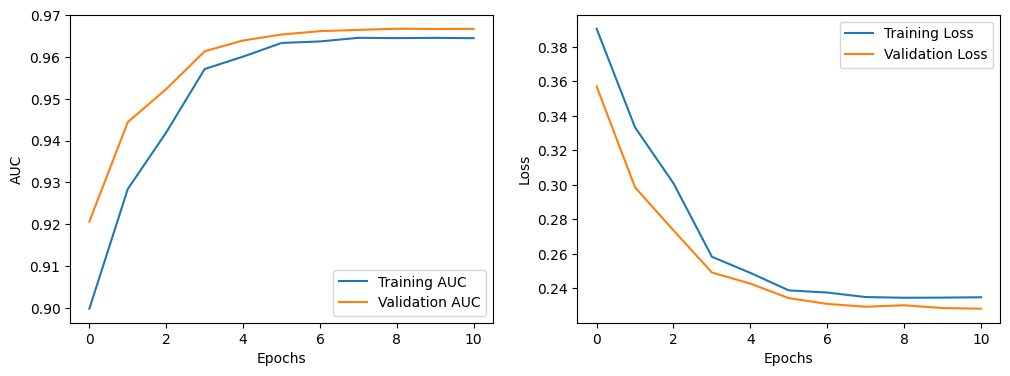

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_best_model.history['AUC'], label='Training AUC')
plt.plot(history_best_model.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_best_model.history['loss'], label='Training Loss')
plt.plot(history_best_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Below, I will use my model to predict the labels for the test dataset.**

In [16]:
# get the IDs that I will test with
test_data = pd.read_csv('data/sample_submission.csv')
image_ids = test_data['id'].values

test_dataset = tf.data.Dataset.from_tensor_slices((test_data['id'].values, test_data['label'].values))

def preprocess_image(path, label):
    full_path = tf.strings.join(['data/test/', path, '.tif'])
    image = tf.py_function(load_tif, [full_path], tf.float32)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0

    label = tf.cast(label, tf.float32)
    return image, label

def load_tif(path):
    image = Image.open(path.numpy().decode('utf-8'))
    image = image.convert('RGB')
    image_arr = np.array(image).astype(np.float32)
    return image_arr

batch_size = 32
buffer_size = 10000

test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=buffer_size)


predictions = best_model.predict(test_dataset)

test_data['label'] = predictions

test_data.to_csv('results.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step


# Discussion & Conclusion

**Here is a screenshot of the submission with a score of 0.8987 and a public score of 0.9330.**
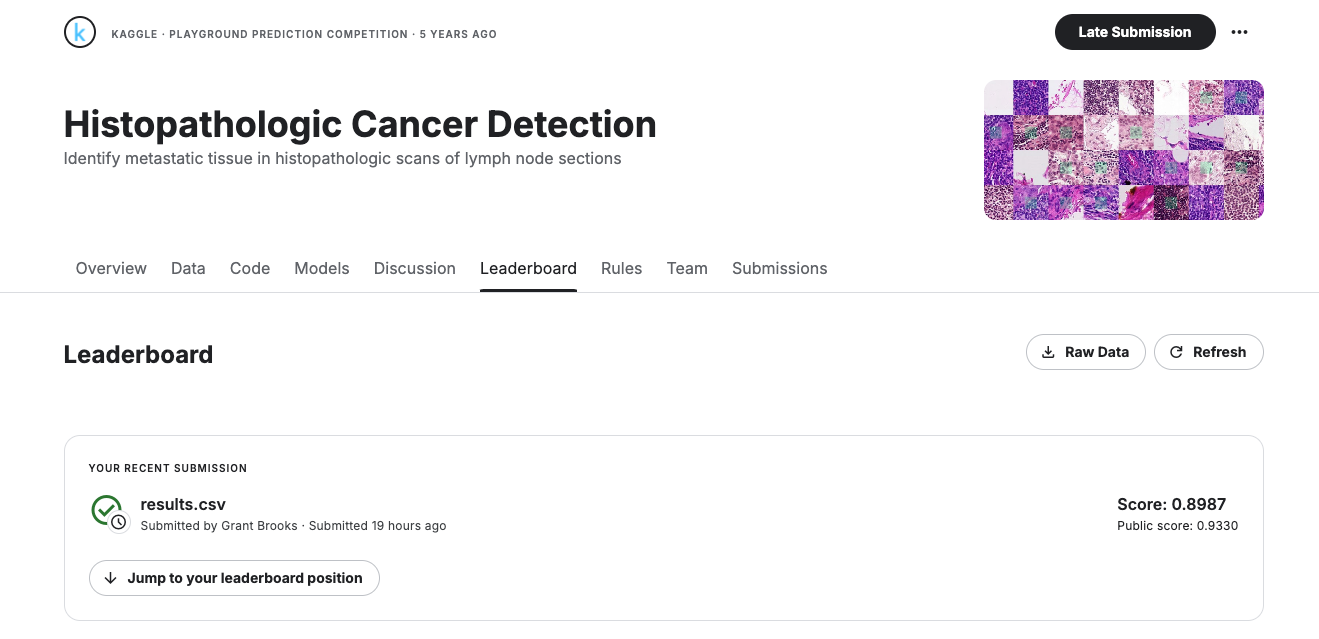

I found that introducing ReduceLROnPlateau and EarlyStopping and tweaking their patience values helped the most with providing stability in the performance on my validation set accross epochs.

My biggest struggle with this project was working with long training times. Many times I had to deal with processes freezing. It took days of trial and error to finally get the `tuner.search` to complete. I learned techniques for getting Tensorflow to utilize a GPU on an M1 Mac to improve speeds and I tweaked the complexity of my model to make it manageable timewise.

In the future, I could see if the performance improves by using images sizes of 96x96 instead of 64x64 -- although this would likely decrease training efficiency. I could also futher experiment with my model architecture and layers, trying different values for their parameters.

*Throughout this project, I used generative AI (specifically ChatGPT 4o) to help improve my understanding and implementation of deep learning processes.*